In [1]:
!pip install torch torchvision transformers tqdm pillow scikit-image
!mkdir -p data/kvasir

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 40.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [3]:
import os
from zipfile import ZipFile


os.makedirs('data/kvasir/images', exist_ok=True)
os.makedirs('data/kvasir/masks', exist_ok=True)
zip_path = 'kvasir-seg.zip'

with ZipFile(zip_path, 'r') as zip_ref:
    for file in zip_ref.namelist():
        if file.endswith('/'):
            continue

        if file.startswith('Kvasir-SEG/images/'):
            filename = os.path.basename(file)
            target_path = os.path.join('data/kvasir/images', filename)
            with zip_ref.open(file) as source, open(target_path, 'wb') as target:
                target.write(source.read())

        elif file.startswith('Kvasir-SEG/masks/'):
            filename = os.path.basename(file)
            target_path = os.path.join('data/kvasir/masks', filename)
            with zip_ref.open(file) as source, open(target_path, 'wb') as target:
                target.write(source.read())

print("Extraction complete.")

Extraction complete.


In [4]:
pip install torchvision pillow

In [5]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms

class KvasirDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, target_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.images = sorted(os.listdir(image_dir))
        self.masks = sorted(os.listdir(mask_dir))
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # grayscale

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            mask = self.target_transform(mask)

        return image, mask

In [9]:
IMG_SIZE = 256

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

mask_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

In [14]:
from torch.utils.data import random_split, DataLoader


dataset = KvasirDataset('data/kvasir/images', 'data/kvasir/masks', transform=transform, target_transform=mask_transform)
total_size = len(dataset)
val_size = int(0.1 * total_size)
train_size = total_size - val_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [15]:
for images, masks in train_loader:
    print("Image batch shape:", images.shape)
    print("Mask batch shape:", masks.shape)
    break

Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 1, 256, 256])


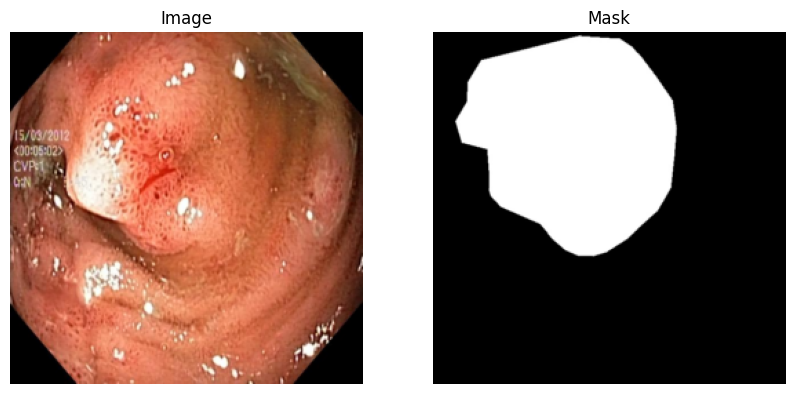

In [16]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF


image, mask = dataset[0]

image_np = TF.to_pil_image((image * 0.5 + 0.5))
mask_np = TF.to_pil_image(mask)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image_np)
plt.title('Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask_np, cmap='gray')
plt.title('Mask')
plt.axis('off')

plt.show()

In [17]:
import torch.nn as nn
import torch

class UNetEncoder(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super(UNetEncoder, self).__init__()
        self.downs = nn.ModuleList()

        for feature in features:
            self.downs.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, feature, kernel_size=3, padding=1),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(feature, feature, kernel_size=3, padding=1),
                    nn.ReLU(inplace=True),
                )
            )
            in_channels = feature

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        features = []
        for down in self.downs:
            x = down(x)
            features.append(x)
            x = self.pool(x)
        return features[-1]

In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
encoder = UNetEncoder().to(device)


for images, masks in train_loader:
    images = images.to(device)
    with torch.no_grad():
        t = encoder(images)
    print("Encoded features shape (t):", t.shape)
    break

Encoded features shape (t): torch.Size([8, 512, 32, 32])


In [19]:
B, C, H, W = t.shape
t_flat = t.view(B, C, -1).permute(0, 2, 1)
print("Flattened shape for LLM:", t_flat.shape)

Flattened shape for LLM: torch.Size([8, 1024, 512])


In [20]:
pip install transformers

In [43]:
from transformers import BertConfig, BertModel

class LLMAdapter(nn.Module):
    def __init__(self, embed_dim=512):
        super().__init__()
        config = BertConfig(
            hidden_size=embed_dim,
            num_hidden_layers=4,
            num_attention_heads=8,
            intermediate_size=embed_dim * 4,
            type_vocab_size=1,   # Set token type vocab to 1 (disable types)
            max_position_embeddings=2048,  # set large enough to fit your sequence length
            pad_token_id=0,
        )
        self.bert = BertModel(config)
        for param in self.bert.parameters():
            param.requires_grad = False  # freeze LLM weights

        self.pre_proj = nn.Linear(embed_dim, embed_dim)
        self.post_proj = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        x = self.pre_proj(x)
        outputs = self.bert(inputs_embeds=x, token_type_ids=None)
        x = outputs.last_hidden_state
        x = self.post_proj(x)
        return x

In [51]:
import torch.nn as nn
import torch

class CNNDecoder(nn.Module):
    def __init__(self, in_channels=512, out_channels=1):
        super(CNNDecoder, self).__init__()
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels, 256, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU()
        )
        self.up2 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU()
        )
        self.dropout = nn.Dropout(p=0.1)
        self.up3 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU()
        )
        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        x = self.up1(x)
        x = self.up2(x)
        x = self.up3(x)
        x = self.final(x)
        return x

In [52]:

class LLM4SegModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = UNetEncoder()
        self.llm = LLMAdapter(embed_dim=512)
        self.decoder = CNNDecoder(in_channels=512)

    def forward(self, x):
        B = x.size(0)
        t = self.encoder(x)  # (B, C=512, H=16, W=16)
        C, H, W = t.size(1), t.size(2), t.size(3)
        t_prime = t.view(B, C, -1).permute(0, 2, 1)  # (B, HW, C)
        t_hat = self.llm(t_prime)  # (B, HW, C)
        t_hat_reshaped = t_hat.permute(0, 2, 1).view(B, C, H, W)  # (B, C, H, W)
        out = self.decoder(t_hat_reshaped)  # (B, 1, H_out, W_out)
        return out

In [40]:
import torch.nn.functional as F
def dice_loss(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    dice = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
    return 1 - dice

In [41]:
def combined_loss(pred, target, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)
    d_loss = dice_loss(pred, target)
    return bce_weight * bce + (1 - bce_weight) * d_loss

In [53]:
import torch.optim as optim
num_epochs = 10
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = LLM4SegModel().to(device)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3, weight_decay=1e-5)

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device).float()
        if masks.dim() == 5:
            masks = masks.squeeze(2)

        optimizer.zero_grad()
        outputs = model(images)
        loss = combined_loss(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device).float()
            if masks.dim() == 5:
                masks = masks.squeeze(2)
            outputs = model(images)
            loss = combined_loss(outputs, masks)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")


Epoch [1/10], Train Loss: 0.5986, Val Loss: 0.5837
Epoch [2/10], Train Loss: 0.5460, Val Loss: 0.5496
Epoch [3/10], Train Loss: 0.5311, Val Loss: 0.5245
Epoch [4/10], Train Loss: 0.5171, Val Loss: 0.5221
Epoch [5/10], Train Loss: 0.5058, Val Loss: 0.5129
Epoch [6/10], Train Loss: 0.5015, Val Loss: 0.5105
Epoch [7/10], Train Loss: 0.4943, Val Loss: 0.5066
Epoch [8/10], Train Loss: 0.4891, Val Loss: 0.5062
Epoch [9/10], Train Loss: 0.4875, Val Loss: 0.5058
Epoch [10/10], Train Loss: 0.4801, Val Loss: 0.5147
